/var/folders/24/j32tgdrn7m126hvrjl8t778m0000gn/T/ipykernel_80133/2760519008.py:24: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  transforms.Resize([resize_size,resize_size], PIL.NEAREST),
/Users/bms/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


trainset
valset
trainLoader
valLoader
Training
epoch 1 train loss :  1.0257937920420137 train acc :  0.7185552040043091
epoch 1 val loss :  1.118791046980265 val acc :  0.7008828601321658
Finish Training
Fin


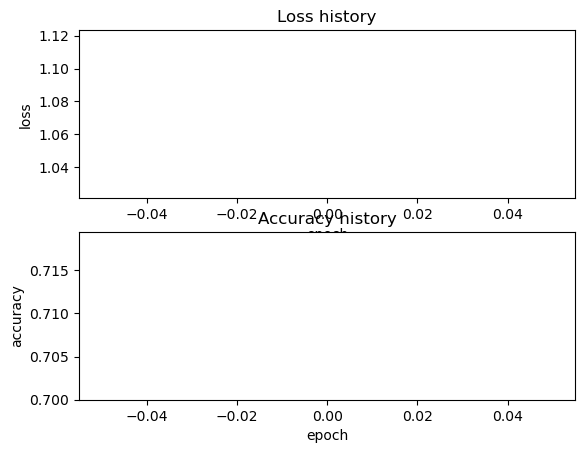

In [2]:
from datasets import Loader
import torchvision.transforms as transforms
import PIL.Image as PIL
from modules_skeleton import *
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from resnet_encoder_unet_skeleton import *

###########################################################################
# Implement the main code.
# Understand loading model, saving model, model initialization,
# setting optimizer and loss, and fill in the blanks.

# batch size
batch_size = 16
learning_rate = 0.001

# VOC2012 data directory
data_dir = "../VOCdevkit/VOC2012"
resize_size = 256

transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize([resize_size,resize_size], PIL.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

print("trainset")
trainset = Loader(data_dir, flag ='train', resize = resize_size, transforms = transforms)
print("valset")
valset = Loader(data_dir, flag = 'val', resize = resize_size, transforms = transforms)

print("trainLoader")
trainLoader = DataLoader(trainset, batch_size = batch_size, shuffle=True)
print("valLoader")
validLoader = DataLoader(valset, batch_size = batch_size, shuffle=True)

##### fill in here #####
##### Hint : Initialize the model (Options : UNet, resnet_encoder_unet)
from UNet_skeleton import *
# model = Unet(in_channels = 3, out_channels = 22) #UNet
model = UNetWithResnet50Encoder() #resnet_encoder_unet
###############################################################################

# Loss Function
##### fill in here -> hint : set the loss function #####
#import torch.nn as nn
criterion = nn.CrossEntropyLoss()

# Optimizer
##### fill in here -> hint : set the Optimizer #####
#import torch
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

scheduler = StepLR(optimizer, step_size=4, gamma=0.1)

# parameters
epochs = 1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

##### fill in here #####
##### Hint : load the model parameter, which is given
# PATH = '../trained_model/UNet_trained_model.pth'
PATH = '../trained_model/resnet_encoder_unet.pth'

checkpoint = torch.load(PATH, map_location=device)
model.load_state_dict(checkpoint)

# Train
import os
from datetime import datetime

now = datetime.now()
date = now.strftime('%Y-%m-%d(%H:%M)')
def createFolder(dir):
    try:
        if not os.path.exists(dir):
            os.makedirs(dir)
    except OSError:
        print('Error: Creating directory. ' + dir)

result_save_dir = './history/result'+date+'/'
createFolder(result_save_dir)
predict_save_dir = result_save_dir + 'predicted/'
createFolder(predict_save_dir)

history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

print("Training")

savepath1 = "./output/model" + date + '/'
createFolder(savepath1)

for epoch in range(epochs):

    train_model(trainLoader, model, criterion, optimizer, scheduler, device)
    train_acc, train_loss = get_loss_train(model, trainLoader, criterion, device)
    print("epoch", epoch + 1, "train loss : ", train_loss, "train acc : ", train_acc)

    predict_save_folder = predict_save_dir + 'epoch' + str(epoch) + '/'
    createFolder(predict_save_folder)
    val_acc, val_loss = val_model(model, validLoader, criterion, device, predict_save_folder)
    print("epoch", epoch + 1, "val loss : ", val_loss, "val acc : ", val_acc)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    if epoch % 4 == 0:
        savepath2 = savepath1 + str(epoch) + ".pth"
        ##### fill in here #####
        ##### Hint : save the model parameter
        torch.save(model.state_dict(), savepath2)

print('Finish Training')

import matplotlib.pyplot as plt

plt.subplot(2,1,1)
plt.plot(range(epoch+1), history['train_loss'], label='Loss', color='red')
plt.plot(range(epoch+1), history['val_loss'], label='Loss', color='blue')

plt.title('Loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show

plt.subplot(2,1,2)
plt.plot(range(epoch+1), history['train_acc'], label='Accuracy', color='red')
plt.plot(range(epoch+1), history['val_acc'], label='Accuracy', color='blue')

plt.title('Accuracy history')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig(result_save_dir+'result')

print("Fin")